# Plotting Light Curves

In [58]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib import style
style.use('seaborn-white')
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags

In [59]:
# Full dataset
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1/classification'
hitsFilename='HiTS_RF_predictions.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename)
hitsTable=fits.open(hitsFilepath) # load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # turn data into a pandas dataframe
hitsDf.head() # shows us what the dataframe looks like

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,CV_Prob,QSO_Prob,SNe_Prob,Predicted_class
0,HiTS090434-041626,Blind15A_02_S1_1856_0087,136.145756,-4.273908,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
1,HiTS090434-042338,Blind15A_02_N1_1253_0089,136.145561,-4.394096,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
2,HiTS090434-042506,Blind15A_02_N1_1587_0054,136.142838,-4.418445,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
3,HiTS090434-042629,Blind15A_02_N1_1903_0088,136.145272,-4.441517,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV
4,HiTS090435-000829,Blind15A_04_S1_0030_0051,136.146090,-0.141399,0.033194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NV


In [60]:
# Subset
hitsDataDir_sub='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename_sub='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath_sub=os.path.join(hitsDataDir_sub,hitsFilename_sub)
hitsTable_sub=fits.open(hitsFilepath_sub) # load data as an astropy fits thing
hitsDf_sub=pd.DataFrame(hitsTable_sub[1].data) # turn data into a pandas dataframe
hitsDf_sub.head() # shows us what the dataframe looks like

,ID,internalID,raMedian,decMedian,Variable_prob,Periodic_prob,DSCT_Prob,EB_Prob,ROTVAR_Prob,RRLYR_Prob,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
0,HiTS095611+020452,Blind15A_26_N1_1715_0146,149.048038,2.081381,0.523601,0.202651,NaN,NaN,NaN,NaN,...,0.246009,-0.584446,0.134705,2.100608,0.032812,0.773151,0.738233,2.859381,1.439736,1.419645
1,HiTS095645+021135,Blind15A_26_N1_0181_2093,149.190225,2.193068,0.564932,0.635018,0.400,0.100,0.375,0.125,...,0.119267,-0.133774,0.067353,-0.444997,0.123052,0.841553,0.815632,0.996040,0.769289,0.226751
2,HiTS095652+023537,Blind15A_26_S14_1446_0379,149.220445,2.593841,0.962477,0.635836,0.025,0.125,0.750,0.100,...,0.227995,-0.317121,0.269410,-0.008631,0.067782,0.849505,0.846981,1.911452,1.484048,0.427403
3,HiTS095702+023628,Blind15A_26_S14_1253_0945,149.261780,2.607883,0.532390,0.933333,0.550,0.225,0.050,0.175,...,0.179956,-0.288333,0.067353,-1.067079,0.181790,0.853063,0.754798,NaN,NaN,NaN
4,HiTS095726+015556,Blind15A_26_N8_1496_2317,149.361376,1.932343,0.972280,0.889344,0.050,0.175,0.625,0.150,...,0.269737,-0.035972,0.740878,-1.731678,0.089139,0.957841,0.948092,1.185192,0.894064,0.291128


In [134]:
#creating dataframes for the QSOs
hitsDfQSO = hitsDf[hitsDf['QSO_Prob'] > 0.80]
hitsDfQSO_sub = hitsDf_sub[hitsDf_sub['QSO_Prob'] > 0.80]
len(hitsDfQSO_sub), len(hitsDfQSO)

(20, 630)

### Just HiTS for now

In [123]:
def plot_hits_full(row, lcPath='/epyc/users/tw94/light_curves_full'):
    '''Plots light curves from HiTS DR1.
    
    Parameters
    ----------
    row : Pandas Dataframe row from DR1 source data
    lcPath : Path on disk to light curves from DR1
    '''
    tok = row['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(row['internalID'].rstrip() + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    fig = plt.figure(figsize=(10, 8))
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', linestyle=':')
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')

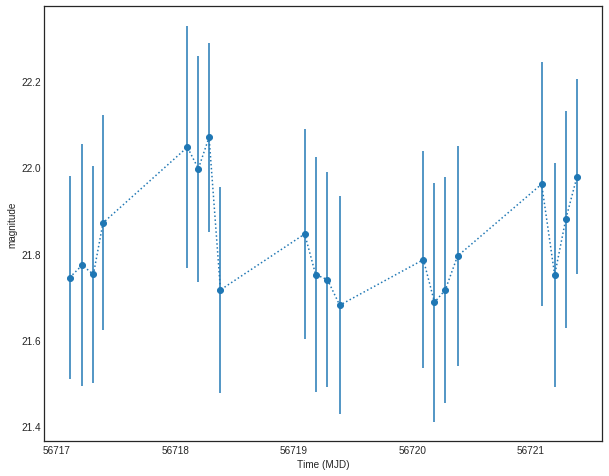

In [127]:
plot_hits_full(hitsDfQSO.iloc[629])

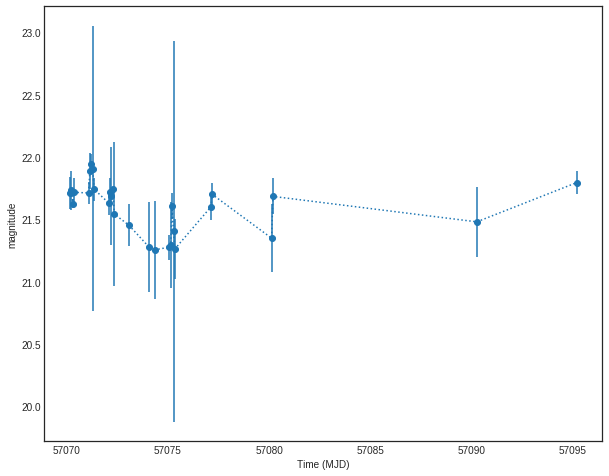

In [135]:
plot_hits_full(hitsDfQSO_sub.iloc[19])

### HiTS and LSST on the Same Plot

In [138]:
repo = '/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1'
butler = dafPersist.Butler(repo)

In [139]:
dbName = 'association.db'
dbPath = os.path.join(repo, dbName)

In [140]:
connection = sqlite3.connect(dbPath)

In [141]:
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection)

In [142]:
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [143]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter']

In [144]:
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable)

/epyc/users/mrawls/lsst_stack/stack/miniconda3-4.5.12-f032070/Linux64/ap_association/18.1.0-14-g371438c+1/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [145]:
lsstQSORas = goodObj.ra
lsstQSODecs = goodObj.decl
hitsQSORas = hitsDfQSO_sub.raMedian_feat
hitsQSODecs = hitsDfQSO_sub.decMedian_feat

153.7979258247111 -3.345603111984352 153.68595916975 -3.3926293200049997


In [146]:
hitsQSOCoords = SkyCoord(ra=hitsQSORas*u.degree, dec=hitsQSODecs*u.degree)
lsstQSOCoords = SkyCoord(ra=lsstQSORas*u.degree, dec=lsstQSODecs*u.degree)
idxRef, d2d, d3d = hitsQSOCoords.match_to_catalog_sky(lsstQSOCoords)

In [147]:
def plotTwoLightcurves(idx, hitsDf, matchIndices, 
                       dbPath='/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1/association.db',
                       lcPath='/epyc/users/tw94/light_curves_full',
                       plotSourceCatLightCurve=False,
                       NSources=10):
    '''Plot a light curve for a DIA (Difference Image Analysis) Object
    from an LSST APDB (Alert Production database), and plot the light curve
    for the same object as measured by the HiTS data release.
    
    Parameters
    ----------
    idx : integer
        specify which of 0-164 HiTS DR1 variables you would like to plot
    hitsDf : Pandas Dataframe containing containing variable objects (HiTS) info
    matchIndices : list or array of integers
        the indices are for lsstCoords corresponding to hitsCoords 0, 1, 2, ... 

    dbPath : Path on disk to an APDB we can load DIA Objects or DIA Sources from
        often the database is named `association.db`
    lcPath : Path on disk to light curves from HiTS DR1
    plotSourceCatLightCurve : boolean, try retrieving source catalog fluxes from LSST for comparison?
        default is False, this is slow but more accurate than forced photometry

    '''
    # Check and see if there are more than NSources comprising the Object, and decide whether to plot it or not
    if goodObj.iloc[matchIndices[idx]]['nDiaSources'] < NSources:
        print(f'Skipping HiTS index {idx} (LSST index {matchIndices[idx]}), fewer than {NSources} DIA Sources in the LSST DIA Object')
        return

    # Use the match index to retrieve the DIA Object ID
    obj = goodObj.iloc[matchIndices[idx]]['diaObjectId']
        
    # Load all sources for this object only
    connection = sqlite3.connect(dbPath)
    forcedSrcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, psFlux, psFluxErr, totFlux, totFluxErr \
                                       from DiaForcedSource where diaObjectId = {obj};', connection)
    srcTable = pd.read_sql_query(f'select diaObjectId, midPointTai, ccdVisitId, psFlux, psFluxErr, totFlux, totFluxErr \
                                 from DiaSource where diaObjectId = {obj};', connection)

    # Convert flux to magnitude
    mags = (np.array(forcedSrcTable['totFlux'])*u.nJy).to(u.ABmag)
    magErrs = 1.0857 / forcedSrcTable['totFluxErr'] / forcedSrcTable['totFlux']
    forcedSrcTable['mags'] = mags
    forcedSrcTable['magErrs'] = magErrs
    
    mags = (np.array(srcTable['totFlux'])*u.nJy).to(u.ABmag)
    magErrs = 1.0857 / srcTable['totFluxErr'] / srcTable['totFlux']
    srcTable['mags'] = mags
    srcTable['magErrs'] = magErrs
    
    plt.figure(figsize=(10,4))
    
    # Retrieve the correct row from the HiTS DR1 dataframe for plotting
    # Use the information in that row to retrieve a HiTS light curve file
    hitsRow = hitsDf.iloc[idx]
    tok = hitsRow['internalID'].split('_')
    field = '_'.join([tok[0], tok[1]])
    ccd = tok[2]
    lightcurveFile = field + '_' + ccd + '_LC_50.tar.gz'
    tarball = tarfile.open(os.path.join(lcPath, field, ccd, lightcurveFile))
    data = tarball.extractfile(hitsRow['internalID'].rstrip() + '_g.dat')
    dfl = pd.read_csv(data, sep='\t')  # load a file with light curve data into a pandas dataframe
    
    # Get some fun classification info about the object from HiTS
    predicted_class = hitsRow['Predicted_class'].strip()
    class_probability = hitsRow[f"{predicted_class}_Prob"]
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIASource position)
    #plt.errorbar(srcTable['midPointTai'], srcTable['mags'], 
    #             yerr=srcTable['magErrs'], ls=':', marker='o', label='LSST Source', color='C0')
    
    # Plot the LSST light curve (forced PSF photometry on calexp at DIAObject position)
    plt.errorbar(forcedSrcTable['midPointTai'], forcedSrcTable['mags'], 
                 yerr=forcedSrcTable['magErrs'], ls=':', marker='o', label='LSST', color='C0')
    
    # Plot the LSST light curve directly from source catalogs
    if plotSourceCatLightCurve:
        objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources \
                              from DiaObject where validityEnd is NULL;', connection)
        sourceCatTimes, sourceCatMags, sourceCatMagErrs = getSourceCatLightCurve(obj, objTable, srcTable, butler)
        plt.errorbar(sourceCatTimes, sourceCatMags, yerr=sourceCatMagErrs, ls=':', marker='o', label='LSST SourceCat', color='C2')
    
    # Plot the HiTS light curve
    plt.errorbar(dfl.MJD, dfl.MAG_AP1, dfl.MAGERR_AP1, marker='o', ls=':', label='HiTS', color='C3')

    # Add some plot labels, and reverse the y-axis so bright stuff is at the top
    plt.gca().invert_yaxis()
    plt.xlabel('Time (MJD)')
    plt.ylabel('magnitude')
    #plt.title(f"HiTS index: {idx} | LSST index: {matchIndices[idx]} | {predicted_class} Probability: {class_probability:0.2f}")
    plt.title(f"HiTS classification: {predicted_class} | Probability: {class_probability:0.2f}")
    plt.legend(frameon=False, prop={'size': 16})

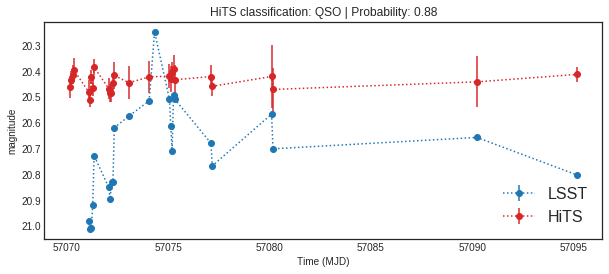

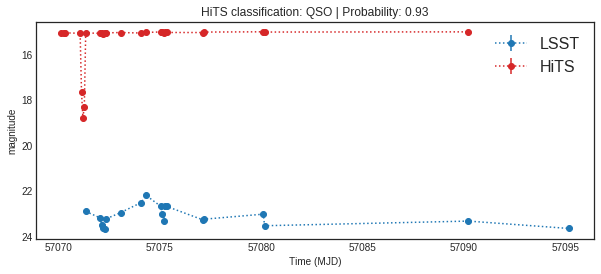

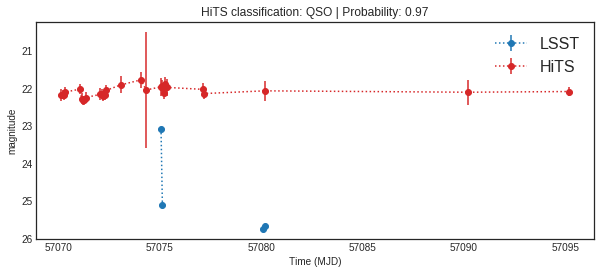

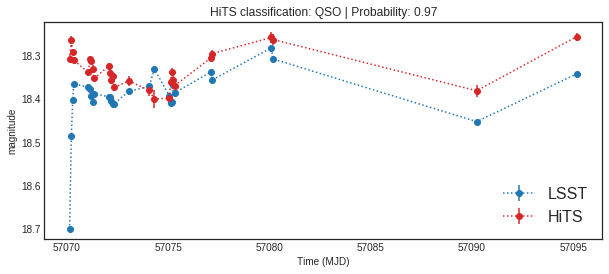

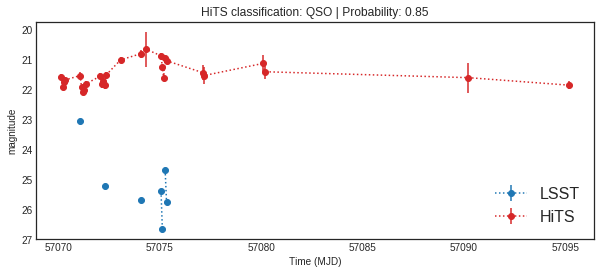

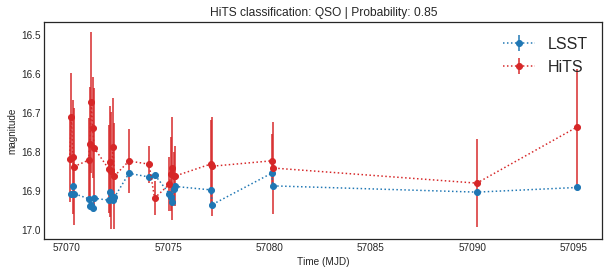

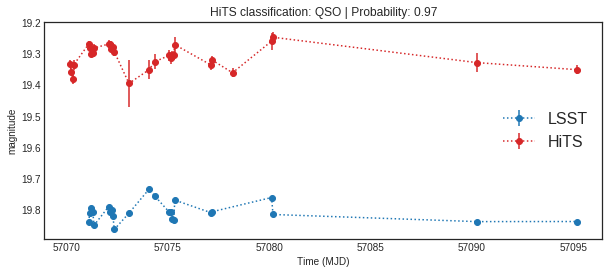

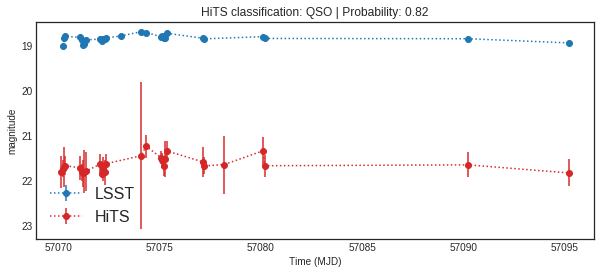

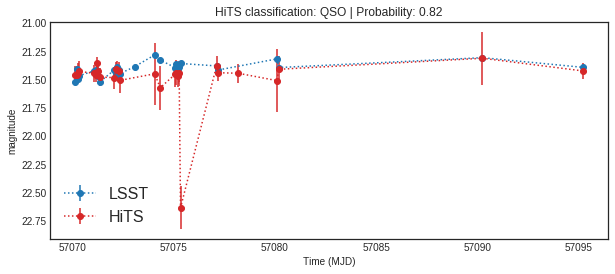

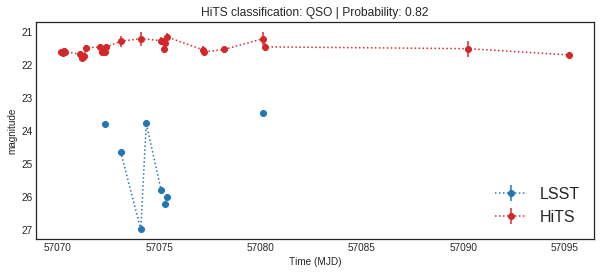

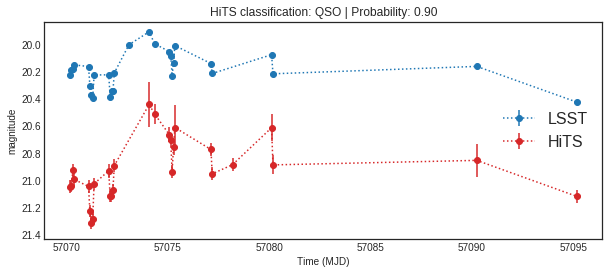

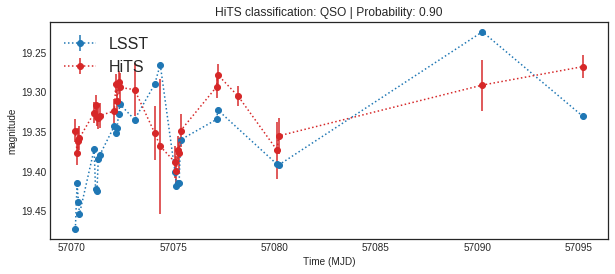

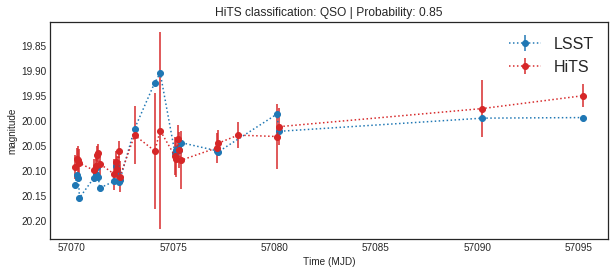

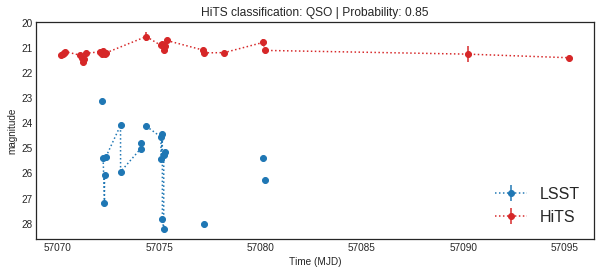

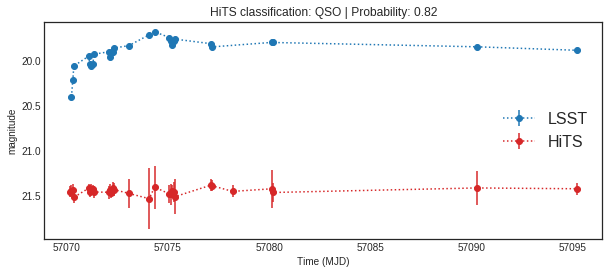

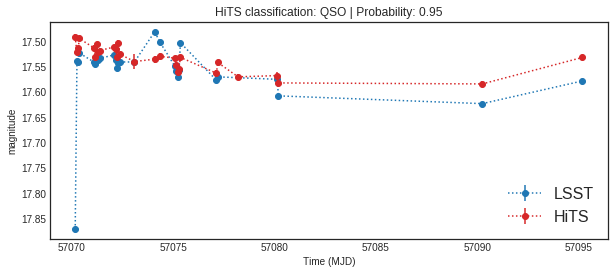

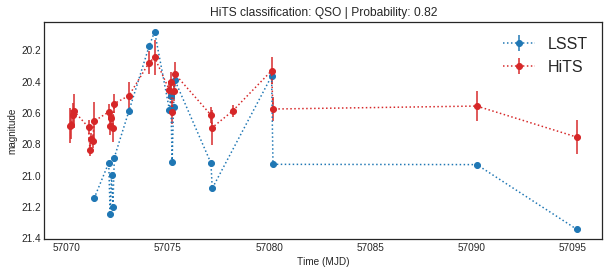

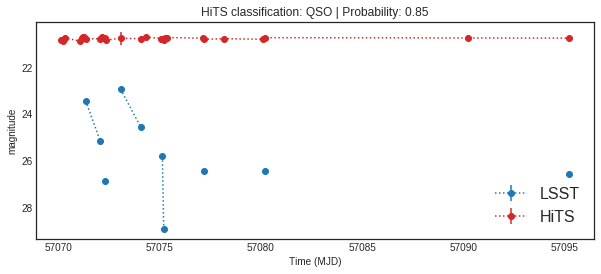

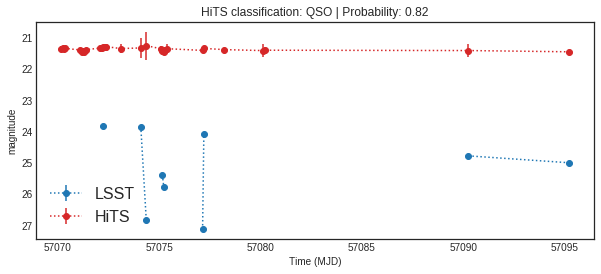

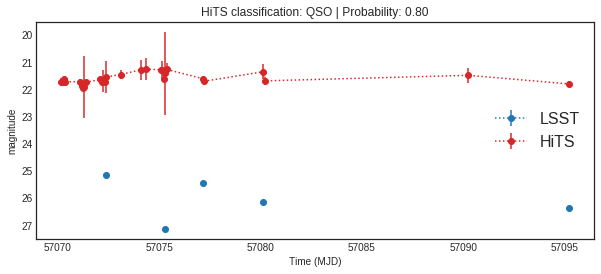

In [152]:
for i in range(20):
    plotTwoLightcurves(i, hitsDf=hitsDfQSO_sub, matchIndices=idxRef, plotSourceCatLightCurve=False, NSources=1)